In [1]:
# imports
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import os
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

input_dir = Path("data") / "raw" / "unsplash"
output_dir = Path("data") / "processed" / "unsplash"

# Preparation

In [ ]:
!mkdir data/
!mkdir data/raw
!mkdir data/processed
!mkdir data/processed/unsplash
!wget https://unsplash.com/data/lite/latest -O data/raw/unsplash.zip
!unzip data/raw/unsplash -d data/raw/unsplash
!rm data/raw/unsplash.zip

In [ ]:
# download the images
df = pd.read_csv(input_dir / "photos.tsv000", sep='\t', header=0)

def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
        background = Image.new("RGB", im.size, (255, 255, 255))
        background.paste(im, mask = im.split()[3])
        return background
    else:
        return im
    
def download_and_process(i):
    try:
        url = df['photo_image_url'][i]
        photo_id = df['photo_id'][i]
        im = Image.open(requests.get(url, stream=True, timeout=2).raw)
        im = remove_transparency(im)
        im.thumbnail((1000, 1000), Image.ANTIALIAS)
        im.save(output_dir / (photo_id + '.jpg'), optimize=True)
    except:
        failed.append(i)

failed = []
for i in tqdm(df.index):
    download_and_process(i)

In [ ]:
!mkdir data/processed/unsplash/train
!mkdir data/processed/unsplash/test
!mkdir data/processed/unsplash/val

all_images = list(Path(output_dir).glob("*.jpg"))
for i, img_p in enumerate(all_images):
    if i < 15000:
        os.rename(img_p, output_dir / "train" / img_p.name)
    elif i < 20000:
        os.rename(img_p, output_dir / "test" / img_p.name)
    else:
        os.rename(img_p, output_dir / "val" / img_p.name)

In [ ]:
# clean out black and white images
import os
all_images = list(Path(output_dir / 'train').glob("*.jpg")) + list(Path(output_dir / 'test').glob("*.jpg")) + list(Path(output_dir / 'val').glob("*.jpg"))
for img in tqdm(all_images):
    try:
        im = Image.open(img)
        im = np.asarray(im)
        if im.ndim != 3 or im.shape[2] == 4:
            os.remove(img)
    except:
        os.remove(img)

# Experiment

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from colorize.models import *
from colorize.datasets import *

## Dataset

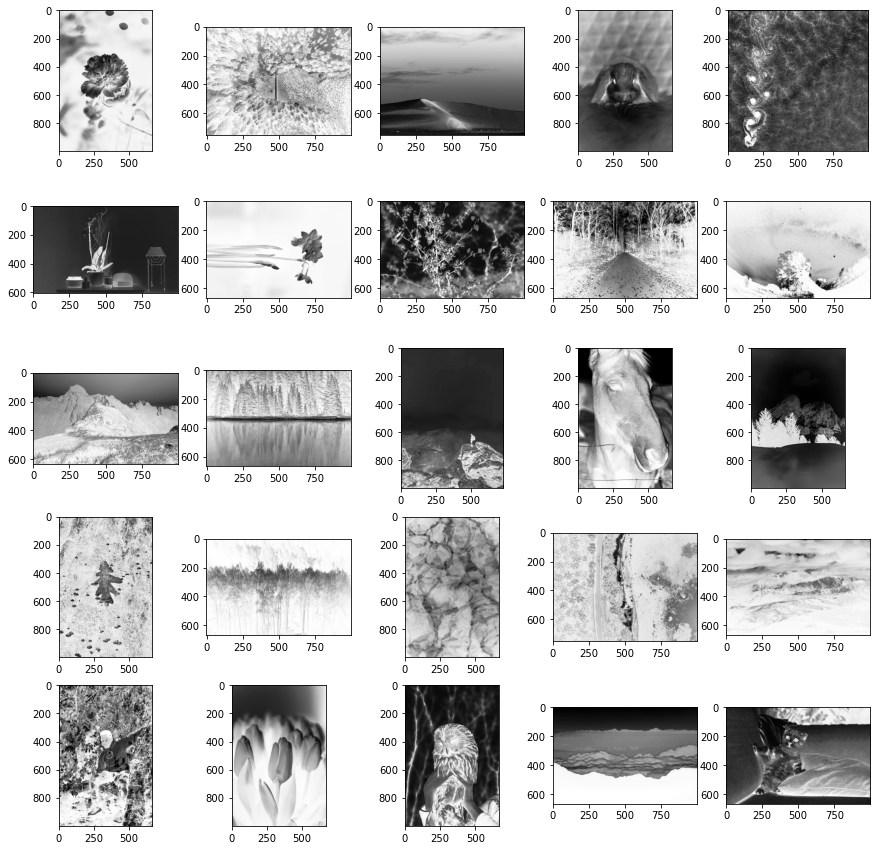

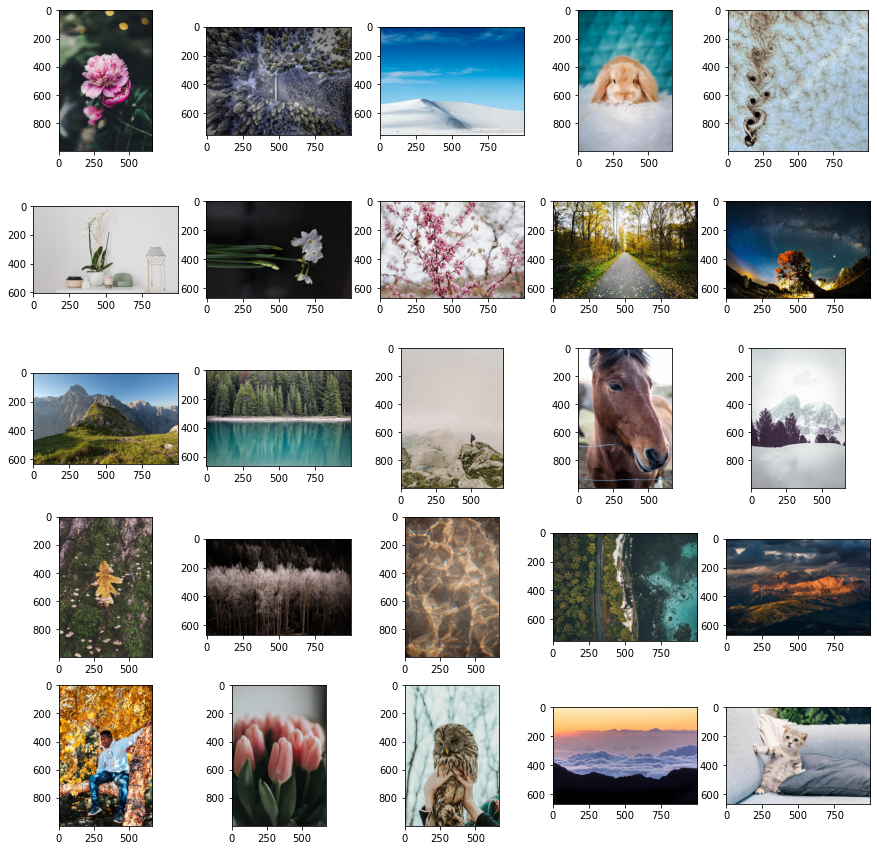

In [3]:
example_dataset = ColorizeDataset(output_dir / 'train')
fig1, axes1 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
fig2, axes2 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        x, y = example_dataset[i * 5 + j]
        axes1[i][j].imshow(x[0], cmap='Greys')
        lab = ColorizeDataset.create_lab(x, y)
        axes2[i][j].imshow(ColorizeDataset.lab2rgb(lab))

## Train

In [3]:
model = UNetGAN()
data = ColorizeDataModule(batch_size=8, image_size=(256,256))

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

logger = pl.loggers.tensorboard.TensorBoardLogger(
    'lightning_logs', name='GAN', version=None
)

trainer = pl.trainer.Trainer(callbacks=[],#[EarlyStopping(monitor='val_loss')], 
                             max_epochs=100, 
                             gpus=1, 
                             logger=logger)

trainer.fit(model, datamodule=data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\alexd\miniconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:45: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name          | Type          | Params
------------------------------------------------
0 | GANLoss       | GANLoss       | 0     
1 | L1Loss        | L1Loss        | 0     
2 | generator     | UNetGenerator | 54.4 M
3 | discriminator | Discriminator | 2.8 M 


Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model, datamodule=data)

In [5]:
eval_model = model.eval().cuda(device=0)

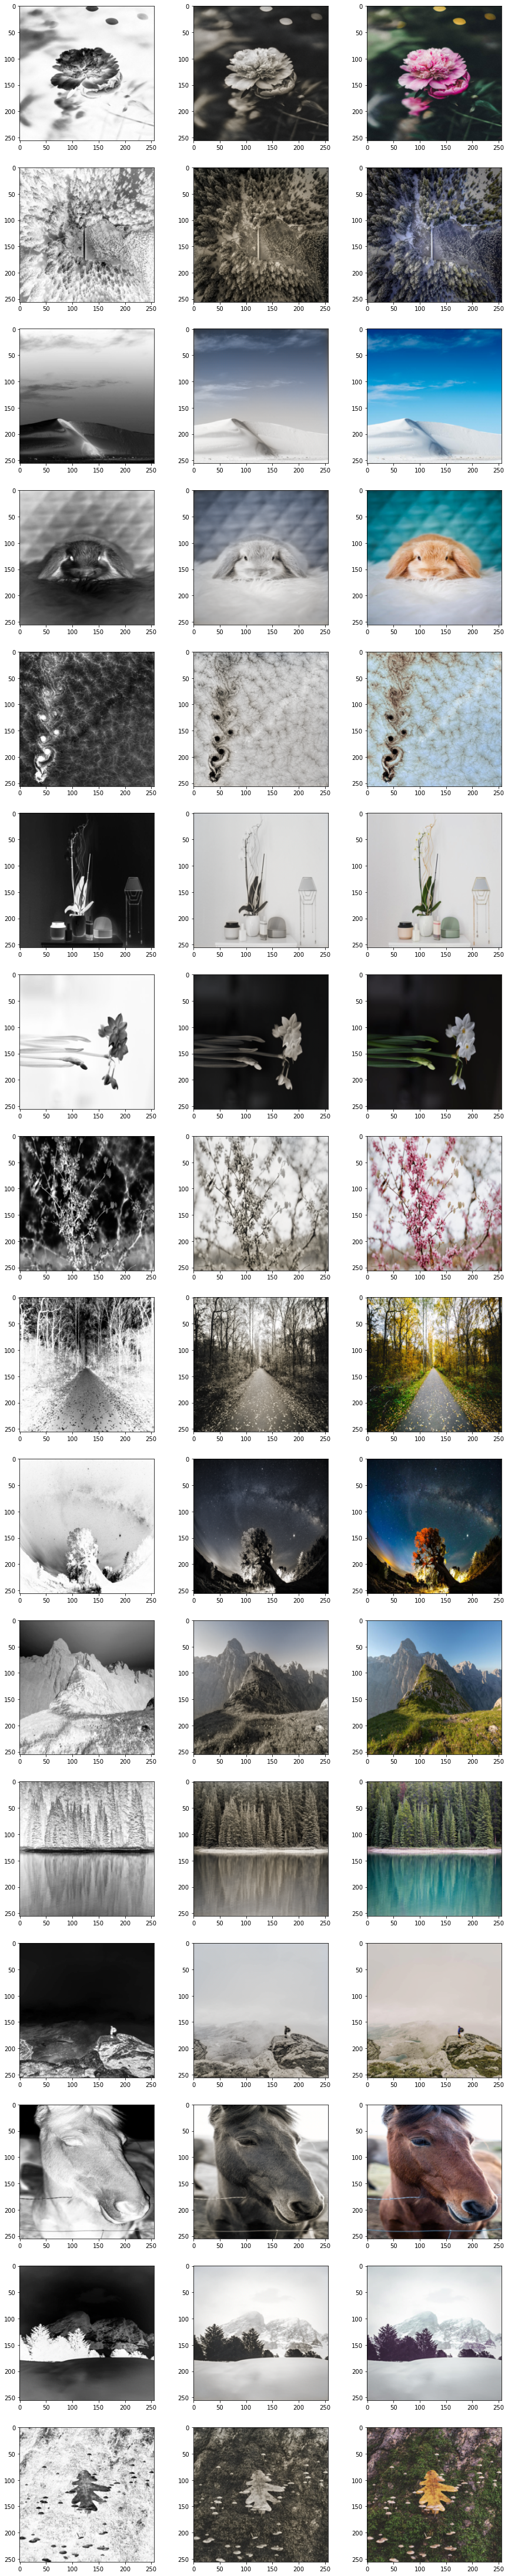

In [7]:
n = 16
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15,n * 5))
for i in range(n):
    x, y = data.train[i]
    axes[i][0].imshow(x[0], cmap='Greys')

    y_pred = eval_model(x.unsqueeze(0).cuda(device=0)).cpu().detach()[0]
    lab_pred = ColorizeDataset.create_lab(x, y_pred)
    axes[i][1].imshow(ColorizeDataset.lab2rgb(lab_pred))

    lab_true = ColorizeDataset.create_lab(x, y)
    axes[i][2].imshow(ColorizeDataset.lab2rgb(lab_true))